# Text Classification with BERT using Neural Modules - Training

Begin by importing all of the required modules/functions/classes.

In [1]:
import nemo
import nemo.collections.nlp as nemo_nlp
from nemo.collections.nlp.data.datasets import BertTextClassificationDataset
from nemo.collections.nlp.nm.data_layers.text_classification_datalayer import BertTextClassificationDataLayer
from nemo.collections.nlp.nm.trainables import SequenceClassifier

from nemo.backends.pytorch.common import CrossEntropyLossNM
from nemo.utils.lr_policies import get_lr_policy
from nemo.collections.nlp.callbacks.text_classification_callback import eval_iter_callback, eval_epochs_done_callback

import os
import json
import math
import numpy as np
import pandas as pd
pd.options.display.max_colwidth = -1

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
%matplotlib inline

import torch

from netapp_jupyter_utils import netappSnapshotCreate, netappGetSnapshots, netappRestoreSnapshot
from datetime import datetime

[NeMo W 2021-08-18 04:49:21 audio_preprocessing:56] Could not import torchaudio. Some features might not work.


You can safely ignore the "UserWarning: Could not import torchaudio. Some features might not work." error this code generates, as this notebook does not utilize any "torchaudio" features.

# NetApp Volume Parameters

Enter the names of the Kubernetes PersistentVolume (PV) objects on which the dataset and model reside. These models are presented as simple folders within the Jupyter workspace through the NetApp AI Control Plane, where the ./data directory is the mounted dataset PV and the ./model directory is the mounted model PV. These PVs were provisioned using NetApp Trident prior to the start of the lab, and are pre-populated with the lab's required dataset and model data.

Notice that the NetApp storage constructs are abstracted away such that the user does not need to know or care that these directories actually represent mounted NetApp volumes, meaning data scientists aren't distracted by storage complexity.

In [2]:
# Note: PV = PersistentVolume
datasetPvName = 'pvc-99ca6eb3-0fbd-45bc-8309-654df8bef276' # Kubernetes PV on which the dataset resides (mounted at ./data)
modelPvName = 'pvc-f96acec3-e9eb-41c5-bcea-210aede85585' # Kubernetes PV on which trained models will be saved (mounted at ./model)

# This just allows Jupyter to re-use these values in the next notebook
%store datasetPvName
%store modelPvName

Stored 'datasetPvName' (str)
Stored 'modelPvName' (str)


# Dataset



Load the dataset.

In [3]:
WORK_DIR = 'logs'
DATA_DIR = 'data/SST-2'
MODELS_DIR = 'models/'

PRETRAINED_MODEL_NAME = 'bert-base-uncased'
MAX_SEQ_LEN = 64 # we will pad with 0's shorter sentences and truncate longer
BATCH_SIZE = 100

df = pd.read_csv(DATA_DIR + '/train.tsv', sep='\t')
test_df = pd.read_csv(DATA_DIR + '/test.tsv', sep='\t')

## Data Exploration

Display the first few lines of the dataset, which are sentences extracted from online movie reviews, to get a sense for what the dataset looks like. Each sentence has a label of 0 or 1, indicating whether that sentence is expressing a negative or positive sentiment, respectively.

In [4]:
df.head()

,sentence,label
0,hide new secretions from the parental units,0
1,"contains no wit , only labored gags",0
2,that loves its characters and communicates something rather beautiful about human nature,1
3,remains utterly satisfied to remain the same throughout,0
4,on the worst revenge-of-the-nerds clichés the filmmakers could dredge up,0


In [5]:
# Split train to train and val and save to disk
np.random.seed(123)
train_mask = np.random.rand((len(df))) < .8
train_df = df[train_mask]
val_df = df[~train_mask]

# Reformat test dataset ("sentence\tlabel")
test_df['label'] = 0
test_df = test_df[['sentence', 'label']]

# Save new train, val, and test to disk
SPLIT_DATA_DIR = os.path.join(DATA_DIR, 'split')

os.makedirs(SPLIT_DATA_DIR, exist_ok=True)

train_df.to_csv(os.path.join(SPLIT_DATA_DIR, 'train.tsv'), sep='\t', index=False)
val_df.to_csv(os.path.join(SPLIT_DATA_DIR, 'eval.tsv'), sep='\t', index=False)
test_df.to_csv(os.path.join(SPLIT_DATA_DIR, 'test.tsv'), sep='\t', index=False)

## Save Dataset Baseline for Traceability

Save the datasets to disk so that you can later take advantage of NetApp Snapshot technology to save baselined dataset versions. The data transformation you performed here was simple, but these transformations are often complex and may require experimentation with multiple augmentations. NetApp Snapshots facilitate that need by giving you the ability to save off different versions of datasets in a near-instantaneous and highly storage-efficient manner. You will create a snapshot in the next section of this notebook.

Before training the model, use NetApp Snapshot technology to near-instaneously save a baseline version of the dataset for traceability.

First, define a unique tag and a description for the training run. You will use these items to identify the snapshots that correspond to this specific training run. 

In [6]:
trainingRunTag = 'bert_%s' % datetime.today().strftime('%Y%m%d_%H%M%S') # Training run tag = bert_timestamp
print('trainingRunTag: ', trainingRunTag)
trainingRunDescription = 'BERT training run.'

# This just allows Jupyter to re-use these values in the next notebook
%store trainingRunTag

trainingRunTag:  bert_20210818_044926
Stored 'trainingRunTag' (str)


Now, trigger the creation of a Snapshot copy to save a baseline version of the dataset.

A NetApp Snapshot copy is a read-only, point-in-time image of a volume. The image consumes minimal storage space and incurs negligible performance overhead because it only records file changes that have occurred since the last Snapshot was taken. This makes Snapshot copies ideal for saving versioned baselines of datasets and models, and for implementing dataset-to-model traceability. Since you are using the NetApp AI Control Plane, the underlying NetApp functionality is abstracted away, meaning you can trigger the creation of a Snapshot copy directly from within the notebook rather than having to navigate to an external NetApp-specific tool.

If you want more details on how this NetApp integration works, the "netappSnapshotCreate" method is defined in the netapp_jupyter_utils.py helper script found in the same directory as this notebook. That script leverages ONTAP REST APIs to create the snapshot on the desired PV. If you want to examine that script more closely, you can open the JupyterLab File Browser and double-click that script file to open it in an editor, just be careful not to change the file's contents or you may break the script, which in turn would break the correct operation of this notebook.

In [7]:
apiResponse, snapshot = netappSnapshotCreate(pvName = datasetPvName, snapshotName = trainingRunTag, snapshotComment = trainingRunDescription)

print('API Response: ', apiResponse['state'])
print('Snapshot uuid: ', snapshot['uuid'])
print('Snapshot name: ', snapshot['name'])
print('Snapshot description: ', snapshot['comment'])
print('Snapshot tag: ', trainingRunTag)

API Response:  success
Snapshot uuid:  a7210eb7-ffdf-11eb-b34c-0050569f4e90
Snapshot name:  bert_20210818_044926
Snapshot description:  BERT training run.
Snapshot tag:  bert_20210818_044926


# Neural Modules

In [8]:
# instantiate the neural module factory
nf = nemo.core.NeuralModuleFactory(log_dir=WORK_DIR,
                                   create_tb_writer=True,
                                   add_time_to_log_dir=False,
                                   optimization_level='O1')

# Pre-trained BERT
bert = nemo_nlp.nm.trainables.huggingface.BERT(pretrained_model_name=PRETRAINED_MODEL_NAME)
tokenizer = nemo_nlp.data.NemoBertTokenizer(PRETRAINED_MODEL_NAME)

print(f'{PRETRAINED_MODEL_NAME} has {bert.num_weights} weights')

[NeMo I 2021-08-18 04:49:40 bert_tokenizer:78] Deriving bert model type from pretrained model name.
bert-base-uncased has 109482240 weights


In [9]:
# mlp classifier
bert_hidden_size = bert.hidden_size

mlp = SequenceClassifier(hidden_size=bert_hidden_size, 
                         num_classes=2,
                         num_layers=2,
                         log_softmax=False,
                         dropout=0.1)

loss = CrossEntropyLossNM()

# Compared to the BERT model, the MLP is tiny.
print(f'MLP has {mlp.num_weights} weights')

MLP has 592130 weights


## Pipelines

Pipelines define how data will flow through the different neural networks. In this case the data will flow through the BERT network and then the MLP network.

Note that this specific use of the term "Pipelines" refers to the general concept of "Pipelines", not to the Kubeflow Pipelines framework.

### Data Layers

Use a pre-built library to convert the data to a format that the BERT model expects.

In [10]:
train_data = BertTextClassificationDataLayer(input_file=os.path.join(SPLIT_DATA_DIR, 'train.tsv'),
                                             tokenizer=tokenizer,
                                             max_seq_length=MAX_SEQ_LEN,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             use_cache=True)

val_data = BertTextClassificationDataLayer(input_file=os.path.join(SPLIT_DATA_DIR, 'eval.tsv'),
                                           tokenizer=tokenizer,
                                           max_seq_length=MAX_SEQ_LEN,
                                           batch_size=BATCH_SIZE,
                                           use_cache=True)

[NeMo I 2021-08-18 04:49:41 text_classification_dataset:217] features restored from data/SST-2/split/cached_train_BertTokenizer_64_30522
[NeMo I 2021-08-18 04:49:41 text_classification_dataset:217] features restored from data/SST-2/split/cached_eval_BertTokenizer_64_30522


In [11]:
train_input, train_token_types, train_attn_mask, train_labels = train_data()
val_input, val_token_types, val_attn_mask, val_labels = val_data()

# Understanding and Visualizing BERT Embeddings

Create BERT embeddings that convert words into a feature vector, and then use a machine learning algorithm called TSNE to separate a list of example words into categories representing "good" (i.e., positive) words and "bad" (i.e., negative) words.

In [12]:
# Write example words to file
spectrum_words = ['abysmal', 'apalling', 'dreadful', 'awful', 'terrible',
                  'very bad', 'really bad', 'rubbish', 'unsatisfactory',
                  'bad', 'poor', 'great', 'really good', 'very good', 'awesome'
                  'fantastic', 'superb', 'brilliant', 'incredible', 'excellent'
                  'outstanding', 'perfect']

spectrum_file = os.path.join(SPLIT_DATA_DIR, 'positive_negative.tsv')
with open(spectrum_file, 'w+') as f:
    f.write('sentence\tlabel')
    for word in spectrum_words:
        f.write('\n' + word + '\t0')

spectrum_df = pd.read_csv(spectrum_file, delimiter='\t')

In [13]:
# Reformat data
spectrum_data = BertTextClassificationDataLayer(input_file=spectrum_file,
                                                tokenizer=tokenizer,
                                                max_seq_length=MAX_SEQ_LEN,
                                                batch_size=BATCH_SIZE)

[NeMo I 2021-08-18 04:49:41 text_classification_dataset:82] data/SST-2/split/positive_negative.tsv: 20
[NeMo I 2021-08-18 04:49:41 data_preprocessing:250] Min: 3 |                  Max: 6 |                  Mean: 3.85 |                  Median: 3.0
[NeMo I 2021-08-18 04:49:41 data_preprocessing:252] 75 percentile: 4.25
[NeMo I 2021-08-18 04:49:41 data_preprocessing:253] 99 percentile: 6.0
[NeMo I 2021-08-18 04:49:41 text_classification_dataset:118] 0 out of 20                         sentences with more than 64 subtokens.
[NeMo I 2021-08-18 04:49:41 text_classification_dataset:175] *** Example ***
[NeMo I 2021-08-18 04:49:41 text_classification_dataset:176] example_index: 0
[NeMo I 2021-08-18 04:49:41 text_classification_dataset:177] subtokens: [CLS] ab ##ys ##mal [SEP]
[NeMo I 2021-08-18 04:49:41 text_classification_dataset:178] sent_label: 0
[NeMo I 2021-08-18 04:49:41 text_classification_dataset:179] input_ids: 101 11113 7274 9067 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [14]:
# Create word embeddings
spectrum_input, spectrum_token_types, spectrum_attn_mask, spectrum_labels = spectrum_data()
spectrum_embeddings = bert(input_ids=spectrum_input,
                           token_type_ids=spectrum_token_types,
                           attention_mask=spectrum_attn_mask)
spectrum_embeddings_tensors = nf.infer(tensors=[spectrum_embeddings])

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
[NeMo I 2021-08-18 04:49:42 actions:695] Evaluating batch 0 out of 1


Draw a plot to visualize the words that the machine model classifies as expressing a "good" versus "bad" sentiment. 

[t-SNE] Computing 19 nearest neighbors...
[t-SNE] Indexed 20 samples in 0.000s...
[t-SNE] Computed neighbors for 20 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 20 / 20
[t-SNE] Mean sigma: 2.210003
[t-SNE] KL divergence after 100 iterations with early exaggeration: 35.297852
[t-SNE] KL divergence after 700 iterations: 0.162491


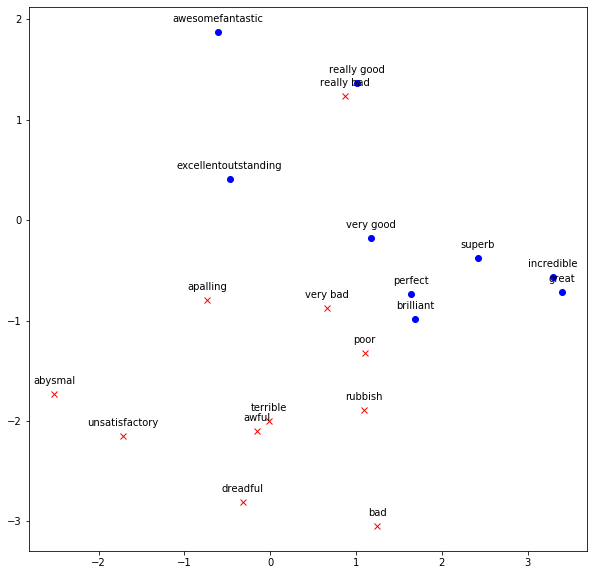

In [15]:
spectrum_activations = spectrum_embeddings_tensors[0][0][:,0,:].numpy()
tsne_spectrum = TSNE(n_components=2, perplexity=10, verbose=1, learning_rate=2,
                     random_state=123).fit_transform(spectrum_activations)

fig = plt.figure(figsize=(10,10))
plt.plot(tsne_spectrum[0:11, 0], tsne_spectrum[0:11, 1], 'rx')
plt.plot(tsne_spectrum[11:, 0], tsne_spectrum[11:, 1], 'bo')
for (x,y, label) in zip(tsne_spectrum[0:, 0], tsne_spectrum[0:, 1], spectrum_df.sentence.values.tolist() ):
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

In the preceding plot, "good" words are denoted by a blue dot, and "bad" words are denoted by a red x. If the model is effective, then you should expect "good" words to be closely clustered together and "bad" words to be closely clustered together, with both cluster groups widely separated into the lower-left and upper-right corners. That is not what you see here, so clearly there is room to improve this model, which you will attempt to accomplish shortly through further training.

# Training Pipeline 

## Save Baseline Version of Model

Before training the model, use NetApp Snapshot technology to save a baseline version of the model that you can revert back to in the event that you are not happy with the upcoming training results. Note that the size of a volume and the amount of data it contains does not factor into the time required to create an ONTAP snapshot. 

In [16]:
modelTag = 'baseline_' + trainingRunTag
modelDescription = 'Baseline pre-trained BERT model.'

bert.config.save_pretrained(MODELS_DIR)
torch.save(bert.state_dict(), MODELS_DIR + 'pytorch_model.bin') # Save pre-trained model to volume

apiResponse, snapshot = netappSnapshotCreate(pvName = modelPvName, snapshotName = modelTag, snapshotComment = modelDescription)

print('API Response: ', apiResponse['state'])
print('Snapshot uuid: ', snapshot['uuid'])
print('Snapshot name: ', snapshot['name'])
print('Snapshot description: ', snapshot['comment'])

API Response:  success
Snapshot uuid:  b38c5f0a-ffdf-11eb-b34c-0050569f4e90
Snapshot name:  baseline_bert_20210818_044926
Snapshot description:  Baseline pre-trained BERT model.


### Set up Training Pipeline

Use BERT embeddings to convert from words to a feature vector. This time you are using the full dataset, not just a small sample.

In [17]:
train_embeddings = bert(input_ids=train_input,
                        token_type_ids=train_token_types,
                        attention_mask=train_attn_mask)
val_embeddings = bert(input_ids=val_input,
                      token_type_ids=val_token_types,
                      attention_mask=val_attn_mask)

#Define optimizations and the loss functions.

NUM_EPOCHS = 3
NUM_GPUS = 1
LEARNING_RATE = 5e-5
OPTIMIZER = 'adam'

train_logits = mlp(hidden_states=train_embeddings)
val_logits = mlp(hidden_states=val_embeddings)

train_loss = loss(logits=train_logits, labels=train_labels)
val_loss = loss(logits=val_logits, labels=val_labels)

### Callbacks

In [20]:
train_data_size = len(train_data)
steps_per_epoch = math.ceil(train_data_size / (BATCH_SIZE * NUM_GPUS))

train_callback = nemo.core.SimpleLossLoggerCallback(tensors=[train_loss, train_logits],
                            print_func=lambda x:nemo.logging.info(f'Train loss: {str(np.round(x[0].item(), 3))}'),
                            tb_writer=nf.tb_writer,
                            get_tb_values=lambda x: [["train_loss", x[0]]],
                            step_freq=steps_per_epoch)

eval_callback = nemo.core.EvaluatorCallback(eval_tensors=[val_logits, val_labels],
                                            user_iter_callback=lambda x, y: eval_iter_callback(x, y, val_data),
                                            user_epochs_done_callback=lambda x:
                                                eval_epochs_done_callback(x, f'{nf.work_dir}/graphs'),
                                            tb_writer=nf.tb_writer,
                                            eval_step=steps_per_epoch)

# Create callback to save checkpoints
ckpt_callback = nemo.core.CheckpointCallback(folder=nf.checkpoint_dir,
                                             epoch_freq=1)

lr_policy_fn = get_lr_policy('WarmupAnnealing',
                             total_steps=NUM_EPOCHS * steps_per_epoch,
                             warmup_ratio=0.1)

[NeMo W 2021-08-18 04:49:53 deprecated:66] Function ``__init__`` is deprecated. It is going to be removed in the 0.12 version. The callback section of NeMo has been updated.


### Train

Train the neural network. This may take up to 5 minutes. If you set up your notebook dashboard with the resource utilization graphs as described in the accompanying lab guide, then you should see GPU Memory utilization graph max out and hold, and GPU Utilization should ramp up, hold, and then drop multiple times as the training process executes each of the model's three epochs. Host CPU utilization will stat relatively low throughout as the GPU is performing most of the training work.

At the beginning of training and at the end of each of the three training epochs, a callback prints a confusion matrix summarizing that epoch's accuracy results, four matrices in total, with values normalized to the range 0.00 to 1.00. The initial matrix will report accuracy around 0.56, while matrices for later epochs will produce around 0.95, reflecting improved model accuracy.

Once training completes, the cell will output four graphical four-square color confusion matrices summarizing these same results. Purple squares in the lower-left and upper-right quadrants represent a more accurate model. While the first graphic does not match this scheme, later ones do, again indicating that model accuracy has improved during the training.

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
[NeMo I 2021-08-18 04:49:53 deprecated_callbacks:195] Starting .....
[NeMo I 2021-08-18 04:49:53 callbacks:534] Found 2 modules with weights:
[NeMo I 2021-08-18 04:49:53 callbacks:536] SequenceClassifier
[NeMo I 2021-08-18 04:49:53 callbacks:536] BERT
[NeMo I 2021-08-18 04:49:53 callbacks:537] Total model parame

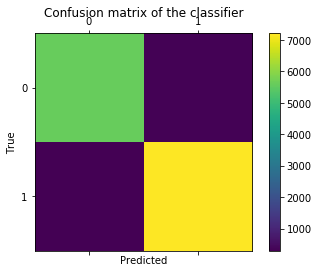

In [22]:
%%time
# Run Training
nf.train(tensors_to_optimize=[train_loss],
         callbacks=[train_callback, eval_callback, ckpt_callback],
         lr_policy=lr_policy_fn,
         optimizer=OPTIMIZER,
         optimization_params={'num_epochs': NUM_EPOCHS, 'lr': LEARNING_RATE})